In [ ]:
import os, json

KEYWORDS = ["wait", "alternatively", "hmm"]

def parse_result_file(file_stem: str, path: str, suffix: str = ".json", keywords=KEYWORDS):
    file_path = os.path.join(path, file_stem + suffix)
    if not os.path.exists(file_path):
        print(f"Missing: {file_path}")
        return None

    correct = 0
    total = 0
    total_len = 0
    total_keyword_count = 0

    with open(file_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            data = json.loads(line)

            if data.get("len", 0) < 10:
                continue

            total += 1
            L = int(data.get("len", 0))
            total_len += L

            if data.get("correct", False):
                correct += 1

            text = (data.get("generated_text", "") or "").lower()
            for kw in keywords:
                total_keyword_count += text.count(kw)

    if total == 0:
        return None

    return {
        "acc": correct / total,
        "avg_len": total_len / total,
        "wait_count": total_keyword_count,
        "n": total,
    }


def parse_tag_budget(file_stem: str, model: str):
    if "begin" in file_stem:
        tag = "begin"
    elif "reason" in file_stem:
        tag = "reason"
    elif "less_think" in file_stem:
        tag = "less_think"
    else:
        tag = "standard"

    budget = None
    if "budget" in file_stem:
        try:
            budget = float(file_stem.split("budget")[-1])
        except Exception:
            budget = None

    if "_False__budget1.0" in file_stem:
        budget = 0.0

    return tag, budget


def collect_results_dict(model: str, files, path: str, suffix: str = ".json", keywords=KEYWORDS):
    results = {}
    for file_stem in files:
        metrics = parse_result_file(file_stem, path=path, suffix=suffix, keywords=keywords)
        if metrics is None:
            continue

        tag, budget = parse_tag_budget(file_stem, model=model)

        key = (tag, budget)
        if key in results:
            print(f"[WARN] duplicate key {key} from file {file_stem}. Overwriting.")
        results[key] = metrics

        print(f"{key} -> acc={metrics['acc']:.3f}, avg_len={metrics['avg_len']:.1f}, wait={metrics['wait_count']}  ({file_stem})")

    return results

In [ ]:
import matplotlib.pyplot as plt

def plot_budget_curve_with_formats(
    results_dict,
    y_key="acc",                 # "acc" / "avg_len" / "wait_count"
    title=None,
    xlabel="Reasoning Budget",
    ylabel=None,
    save_path=None,
    dpi=300
):
    ref_key = ("standard", 1.0)
    if ref_key not in results_dict:
        raise KeyError(f"Missing {ref_key} in results_dict (needed for normalization).")
    ref_len = float(results_dict[ref_key]["avg_len"])

    std_points = []
    for (fmt, b), v in results_dict.items():
        if fmt != "standard":
            continue
        b = float(b)
        y = float(v[y_key])

        if b == 0.0:
            x = 0.0
        elif b == 1.0:
            x = 1.0
        else:
            x = float(v["avg_len"]) / ref_len

        std_points.append((x, y, b))

    std_points.sort(key=lambda t: t[0])
    x_std = [t[0] for t in std_points]
    y_std = [t[1] for t in std_points]

    other_points = {}
    for (fmt, b), v in results_dict.items():
        if fmt == "standard":
            continue
        x = float(v["avg_len"]) / ref_len
        y = float(v[y_key])
        other_points.setdefault(fmt, []).append((x, y))

    fig, ax = plt.subplots(figsize=(4.5, 2.3))

    ax.plot(
        x_std, y_std,
        linewidth=2.2,
        marker="o",
        markersize=8.5,         
        label="standard"
    )

    marker_map = {"begin": "D", "reason": "s", "less_think": "^"}
    red_color = "#d62728"

    for fmt, pts in other_points.items():
        xs = [p[0] for p in pts]
        ys = [p[1] for p in pts]
        ax.scatter(
            xs, ys,
            s=120,             
            marker=marker_map.get(fmt, "o"),
            color=red_color,
            edgecolors="black",
            linewidths=1.0,    
            label=fmt,
            zorder=3
        )

    if ylabel is None:
        ylabel = {
            "acc": "Accuracy",
            "avg_len": "Avg. Output Length",
            "wait_count": "Wait Count"
        }.get(y_key, y_key)

    ax.set_xlabel(xlabel, fontsize=12, fontweight="bold")
    ax.set_ylabel(ylabel, fontsize=12, fontweight="bold")
    if title:
        ax.set_title(title, fontsize=12, fontweight="bold")

    ax.tick_params(axis="both", labelsize=11)
    ax.grid(True, linestyle="--", linewidth=0.8, alpha=0.5)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    all_y = list(y_std)
    for pts in other_points.values():
        all_y.extend([p[1] for p in pts])

    y_min, y_max = min(all_y), max(all_y)
    pad = 0.08 * (y_max - y_min) if y_max > y_min else 0.02
    ax.set_ylim(y_min - pad, y_max + pad)

    # ax.legend(fontsize=10, frameon=False, loc="lower right")
    ax.legend(
        fontsize=10,
        frameon=False,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.95),
        ncol=4,
        handletextpad=0.4,
        columnspacing=1.0
    )

    fig.tight_layout()
    if save_path is not None:
        fig.savefig(save_path, bbox_inches="tight", dpi=dpi)

    return fig, ax

## MATH500

('begin', 1.0) -> acc=0.920, avg_len=3198.2, wait=28700  (Qwen3-32B_False_begin_budget1.0)
('reason', 1.0) -> acc=0.888, avg_len=2812.9, wait=24111  (Qwen3-32B_False_reason_budget1.0)
('less_think', 1.0) -> acc=0.924, avg_len=3062.1, wait=25521  (Qwen3-32B_False_less_think_budget1.0)
('standard', 0.0) -> acc=0.838, avg_len=813.5, wait=198  (Qwen3-32B_False__budget1.0)
('standard', 0.1) -> acc=0.914, avg_len=2419.1, wait=22518  (Qwen3-32B_True__budget0.1)
('standard', 0.2) -> acc=0.916, avg_len=2842.0, wait=27732  (Qwen3-32B_True__budget0.2)
('standard', 0.3) -> acc=0.914, avg_len=3054.2, wait=30736  (Qwen3-32B_True__budget0.3)
('standard', 0.4) -> acc=0.928, avg_len=3138.4, wait=34144  (Qwen3-32B_True__budget0.4)
('standard', 0.5) -> acc=0.936, avg_len=3230.7, wait=38543  (Qwen3-32B_True__budget0.5)
('standard', 0.6) -> acc=0.935, avg_len=3514.5, wait=42973  (Qwen3-32B_True__budget0.6)
('standard', 1.0) -> acc=0.950, avg_len=4734.4, wait=53891  (Qwen3-32B_True__budget1.0)


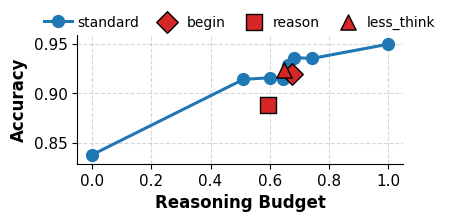

In [ ]:
# -------------------- usage --------------------
dataset, n, model = 'MATH-500',5,'Qwen3-32B'
path = os.path.join('/expert/no_think_rl', dataset, str(n))
files = [
    f"{model}_False_begin_budget1.0",
    f"{model}_False_reason_budget1.0",
    f"{model}_False_less_think_budget1.0",
    f"{model}_False__budget1.0",
    f"{model}_True__budget0.1",
    f"{model}_True__budget0.2",
    f"{model}_True__budget0.3",
    f"{model}_True__budget0.4",
    f"{model}_True__budget0.5",
    f"{model}_True__budget0.6",
    f"{model}_True__budget1.0",
]

results_dict = collect_results_dict(model, files, path=path)
# results_dict[(tag, budget)] => {"acc":..., "avg_len":..., "wait_count":..., "n":...}
fig, ax = plot_budget_curve_with_formats(
    results_dict,
    y_key="acc",
    title=None,
    save_path=f'./budget2/{dataset}-{n}-{model}.pdf'
)
plt.show()

('begin', 1.0) -> acc=0.691, avg_len=11912.0, wait=18320  (Qwen3-32B_False_begin_budget1.0)
('reason', 1.0) -> acc=0.713, avg_len=11032.4, wait=16843  (Qwen3-32B_False_reason_budget1.0)
('less_think', 1.0) -> acc=0.676, avg_len=11101.4, wait=15679  (Qwen3-32B_False_less_think_budget1.0)
('standard', 0.0) -> acc=0.222, avg_len=2812.3, wait=188  (Qwen3-32B_False__budget1.0)
('standard', 0.1) -> acc=0.578, avg_len=10106.4, wait=15914  (Qwen3-32B_True__budget0.1)
('standard', 0.2) -> acc=0.587, avg_len=10022.9, wait=17571  (Qwen3-32B_True__budget0.2)
('standard', 0.3) -> acc=0.631, avg_len=10572.9, wait=19476  (Qwen3-32B_True__budget0.3)
('standard', 0.4) -> acc=0.684, avg_len=11461.8, wait=21173  (Qwen3-32B_True__budget0.4)
('standard', 0.5) -> acc=0.693, avg_len=11492.8, wait=22811  (Qwen3-32B_True__budget0.5)
('standard', 0.6) -> acc=0.700, avg_len=12018.0, wait=24255  (Qwen3-32B_True__budget0.6)
('standard', 1.0) -> acc=0.771, avg_len=14765.1, wait=28217  (Qwen3-32B_True__budget1.0)


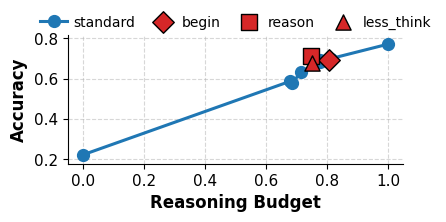

In [ ]:
# -------------------- usage --------------------
dataset, n, model = 'aimo-validation-aime',5,'Qwen3-32B'
path = os.path.join('/expert/no_think_rl', dataset, str(n))
files = [
    f"{model}_False_begin_budget1.0",
    f"{model}_False_reason_budget1.0",
    f"{model}_False_less_think_budget1.0",
    f"{model}_False__budget1.0",
    f"{model}_True__budget0.1",
    f"{model}_True__budget0.2",
    f"{model}_True__budget0.3",
    f"{model}_True__budget0.4",
    f"{model}_True__budget0.5",
    f"{model}_True__budget0.6",
    f"{model}_True__budget1.0",
]

results_dict = collect_results_dict(model, files, path=path)
# results_dict[(tag, budget)] => {"acc":..., "avg_len":..., "wait_count":..., "n":...}
fig, ax = plot_budget_curve_with_formats(
    results_dict,
    y_key="acc",
    title=None,
    save_path=f'./budget2/{dataset}-{n}-{model}.pdf'
)
plt.show()

('begin', 1.0) -> acc=0.548, avg_len=3525.1, wait=17439  (Qwen3-32B_False_begin_budget1.0)
('reason', 1.0) -> acc=0.534, avg_len=2859.1, wait=14849  (Qwen3-32B_False_reason_budget1.0)
('less_think', 1.0) -> acc=0.503, avg_len=2939.6, wait=11145  (Qwen3-32B_False_less_think_budget1.0)
('standard', 0.0) -> acc=0.480, avg_len=1066.3, wait=296  (Qwen3-32B_False__budget1.0)
('standard', 0.1) -> acc=0.428, avg_len=2057.8, wait=7956  (Qwen3-32B_True__budget0.1)
('standard', 0.2) -> acc=0.415, avg_len=2739.8, wait=13295  (Qwen3-32B_True__budget0.2)
('standard', 0.3) -> acc=0.455, avg_len=3347.0, wait=17826  (Qwen3-32B_True__budget0.3)
('standard', 0.4) -> acc=0.491, avg_len=3885.7, wait=22443  (Qwen3-32B_True__budget0.4)
('standard', 0.5) -> acc=0.475, avg_len=4464.8, wait=25932  (Qwen3-32B_True__budget0.5)
('standard', 0.6) -> acc=0.501, avg_len=5110.6, wait=29973  (Qwen3-32B_True__budget0.6)
('standard', 1.0) -> acc=0.641, avg_len=7661.1, wait=41737  (Qwen3-32B_True__budget1.0)


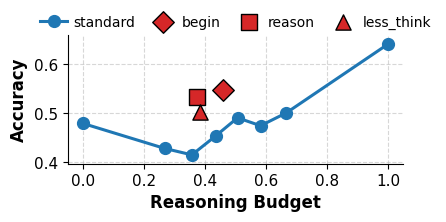

In [ ]:
# -------------------- usage --------------------
dataset, n, model = 'gpqa',5,'Qwen3-32B'
path = os.path.join('/expert/no_think_rl', dataset, str(n))
files = [
    f"{model}_False_begin_budget1.0",
    f"{model}_False_reason_budget1.0",
    f"{model}_False_less_think_budget1.0",
    f"{model}_False__budget1.0",
    f"{model}_True__budget0.1",
    f"{model}_True__budget0.2",
    f"{model}_True__budget0.3",
    f"{model}_True__budget0.4",
    f"{model}_True__budget0.5",
    f"{model}_True__budget0.6",
    f"{model}_True__budget1.0",
]

results_dict = collect_results_dict(model, files, path=path)
# results_dict[(tag, budget)] => {"acc":..., "avg_len":..., "wait_count":..., "n":...}
fig, ax = plot_budget_curve_with_formats(
    results_dict,
    y_key="acc",
    title=None,
    save_path=f'./budget2/{dataset}-{n}-{model}.pdf'
)
plt.show()